In [27]:
import segno
from segno import consts
import os
import random
import string
import io
from PIL import Image
from PIL import ImageOps
from utils import get_local_folder, get_random_background_path
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import cv2
from pyzbar.pyzbar import decode
background_folder = get_local_folder()
background_folder = os.path.dirname(background_folder)
background_folder = os.path.dirname(background_folder)
background_folder = os.path.dirname(background_folder)
background_folder = os.path.join(background_folder, "checker")
background_folder = os.path.join(background_folder, "src")
background_folder = os.path.join(background_folder, "backgrounds_org")
current_folder = get_local_folder()
N = 100



In [28]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        diff = time2-time1
        print(f'{f.__name__} took {diff:.2f} s')
        print(f'{f.__name__} took {diff/N:.5f} s per iteration')
        return ret
    return wrap


In [36]:



def stress(SCALE, BORDER, iterations):
    original_image = Image.open(get_random_background_path(background_folder))
    flag = 'ENO'+''.join(random.choices(string.ascii_letters +
                                        string.digits + '\/=', k=48))
    qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
    qr_size = qr.symbol_size(scale=SCALE, border=BORDER)
    original_image = ImageOps.contain(original_image, qr_size)
    processed_image = original_image.copy()
    box_image = Image.new('RGB', qr_size, (255, 255, 255))
    paste_x = (qr_size[0] - processed_image.size[0]) // 2
    paste_y = (qr_size[1] - processed_image.size[1]) // 2
    box_image.paste(processed_image, (paste_x, paste_y))
    box_image = box_image.convert('RGBA')

    keep_modules = (consts.TYPE_FINDER_PATTERN_DARK, consts.TYPE_FINDER_PATTERN_LIGHT, consts.TYPE_SEPARATOR,
                    consts.TYPE_ALIGNMENT_PATTERN_DARK, consts.TYPE_ALIGNMENT_PATTERN_LIGHT, consts.TYPE_TIMING_DARK,
                    consts.TYPE_TIMING_LIGHT)
    border_offset = BORDER * SCALE
    d = SCALE // 3
    holed_image = box_image.copy()
    qr_size_small = qr.symbol_size(scale=SCALE, border=0)
    # mask_image = Image.new('RGBA', qr_size_small, (0, 0, 0, 0))
    mask_image = np.zeros((qr_size_small[1], qr_size_small[0]), dtype=np.uint8)
    for i, row in enumerate(qr.matrix_iter(scale=SCALE, border=BORDER, verbose=True)):
        for j, m in enumerate(row):
            # if qr_code keep_modules goes here make it transparent
            if m in keep_modules:
                holed_image.putpixel((i, j), (0, 0, 0, 0))
                # mask_image.putpixel((i-border_offset, j-border_offset), (255, 255, 255, 255))
                mask_image[j-border_offset, i-border_offset] = 255
            # if in qr code and not in border
            if (i > border_offset and j > border_offset) and (i < qr_size[0] - border_offset and j < qr_size[1] - border_offset):
                if (((i // d) % 3 == 1) and ((j // d) % 3 == 1)):
                    holed_image.putpixel((i, j), (0, 0, 0, 0))
                    # mask_image.putpixel((i-border_offset, j-border_offset), (255, 255, 255, 255))
                    mask_image[j-border_offset, i-border_offset] = 255
    save_path = os.path.join(current_folder, "holed_image.png")
    holed_image.save(save_path)
    mask_image = cv2.copyMakeBorder(mask_image, border_offset, border_offset, border_offset, border_offset, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # def gen_qr(border, scale, img_path):
    #     final_image = Image.open(img_path)
    #     qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
    #     qr_image = io.BytesIO()
    #     qr.save(qr_image, kind='png', border=border, scale=scale)
    #     qr_image = Image.open(qr_image)
    #     qr_image = qr_image.convert('RGBA')
    #     qr_image.paste(final_image, (0, 0), final_image)
    
    
    final_image = cv2.imread(save_path)
    def gen_qr(border, scale, img_path):
        border_offset = border * scale
        qr = segno.make_qr(flag, error='L', boost_error=False, version=4)
        qr_image = io.BytesIO()
        qr.save(qr_image, kind='png', scale=scale, border=0)
        qr_image = Image.open(qr_image).convert('RGB')
        # qr_image = qr_image.convert('RGBA')
        qr_image = np.array(qr_image)
        qr_image = cv2.copyMakeBorder(qr_image, border_offset, border_offset, border_offset, border_offset, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        # qr_image = cv2.cvtColor(qr_image, cv2.COLOR_RGB2BGR)
        final_image[mask_image == 255] = qr_image[mask_image == 255]
        # cv2.imshow('image', final_image)
        # cv2.waitKey(0)
        qr_data = decode(final_image)
        # If QR code is detected, return the decoded data
        if qr_data:
            print( qr_data[0].data.decode('utf-8'))
        else:
            print("QR code not detected")


    def loop_gen_qr():
        for _ in range(iterations):
            gen_qr(BORDER, SCALE, save_path)

    time_taken = time.time()
    loop_gen_qr()
    time_taken = time.time() - time_taken
    os.remove(save_path)
    return time_taken





In [37]:
stress(12, 100, 1)

ENOL\S13cst7CJpbJLiaMXfgOlA6RKstzJBeM3GD520JTwqFJv\


0.3284580707550049

In [31]:
data = [0 for _ in range(N)]
for i in tqdm(range(N), total=N):
    data[i] = stress(12, i, N)


100%|██████████| 100/100 [07:27<00:00,  4.48s/it]


In [32]:
name = 'test'
import json
with open(name+'.json', 'w') as f:
    json.dump(data, f)
    


In [33]:
import json
with open(name+'.json', 'r') as f:
    data = json.load(f)

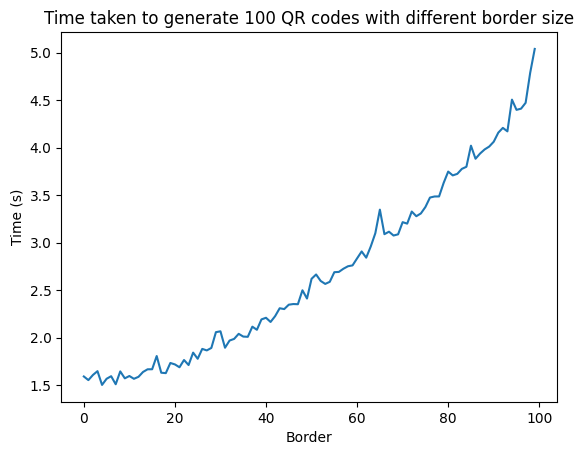

In [34]:
plot, ax = plt.subplots()
ax.plot(data)
ax.set(xlabel='Border', ylabel='Time (s)',
         title=f'Time taken to generate {N} QR codes with different border size')
plot.savefig(name+'.png')


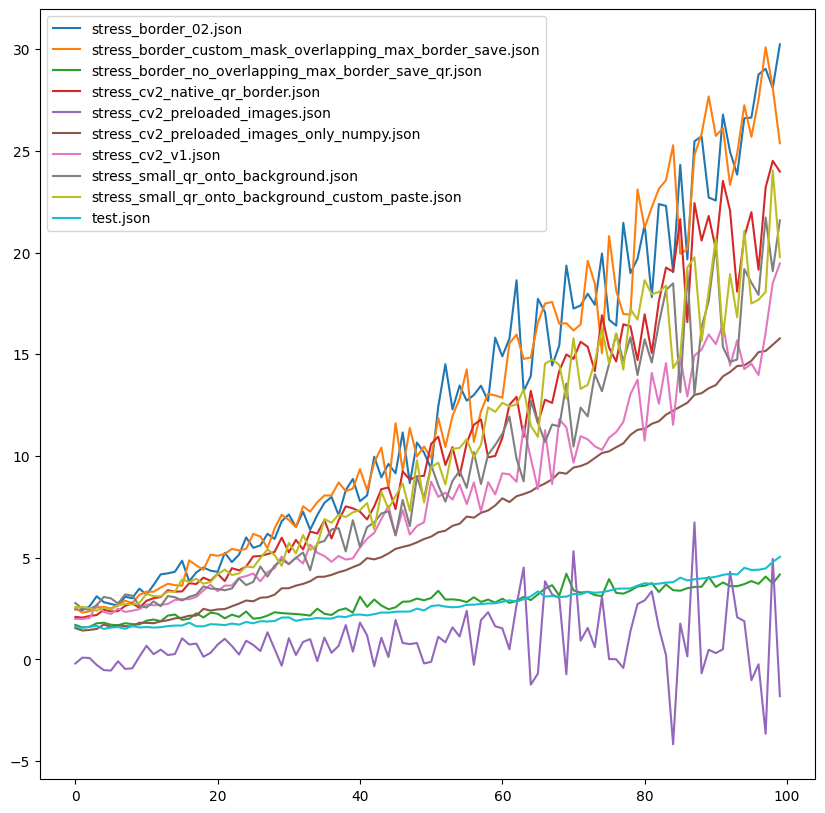

In [35]:
all_json = os.listdir()
all_json = [i for i in all_json if i.endswith('.json')]
plot, ax = plt.subplots(figsize=(10, 10))
for i in all_json:
    with open(i, 'r') as f:
        data = json.load(f)
    ax.plot(data, label=i)
ax.legend()
